#### Summary:
In this notebook I will make 2 new DL CNN models based on active enhancers: one for homeostatic KCs (based on peaks from control C57 KCs) and one for differential peaks in NASH (based on peaks specific for AMLN C57 KCs, with control peaks as background). For the second model I will also adjust the partitioning of data to maximize the amount of data in the training set, by getting rid of a testing set.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
from collections import Counter

import sys
import random

import os
import fnmatch

import sys

# prepare data

Troubleshooting that maybe didn't work

In [2]:
#both of these can be imported to python in the terminal in zs-deeplift env

from Bio import SeqIO
from Bio.Seq import Seq

In [3]:
def load_genome(ref_path):
    ref_dict = {}
    for seq in SeqIO.parse(ref_path, "fasta"):
        chromID = seq.id
        chromSeq = (str(seq.seq)).upper()
        ref_dict[chromID] = chromSeq
    return ref_dict

In [4]:
ref_path = "/home/zes017/genomes/mm10/mm10.fa"
genomes = load_genome(ref_path)

### BED/peak file

In [5]:
def data_prep(path, genomes, label, size=500, rep=1, shift=None):
    print ("Scaled to %d" % (size))
    if shift is None:
        shifts = size//rep*np.arange(-rep//2+1,rep//2+1)
    elif type(shift) is int:
        shifts = np.abs(shift)*np.arange(-rep//2+1,rep//2+1)
    elif type(shift) is list:
        if len(shift) != rep:
            raise TypeError("Number of shift unequal to replicates")
        shifts = np.array(shift)
    if rep == 1 and shift is not None:
        random_shift = True
        print("Random shifting within %s" % (str(-np.abs(shift))+'~'+str(np.abs(shift))))
    else:
        random_shift = False
        print("Generate replicates by shifting %s bp" % (','.join(shifts.astype(str))))
    
    data_list = []
    for line in open(path):
        elems = line.split()
        chromID = elems[0]
        start, end = int(elems[1]), int(elems[2])
        length = end-start
        mid = (start+end)//2
        for s in shifts:
            if random_shift:
                new_mid = mid + np.random.choice(np.arange(-np.abs(shift), np.abs(shift)+1))
            else:
                new_mid = mid + s
            start = new_mid - size//2
            end = new_mid + size//2
            seq = genomes[chromID][start:end]
            if len(seq) != size:
                continue
            data_point = (seq, label, chromID, start, end)
            data_list.append(data_point)
    return data_list

In [17]:
#homeostatic model
pos_data_path = "/home/hmummey/data/ATAC/annotated_peak_calling/round3/C57_control_round3_filt_annot_fin.bed"
pos_data_homeo = data_prep(pos_data_path, genomes, 1, size=300, rep=1, shift=None)
neg_data_path = "/home/hmummey/data/ATAC/annotated_peak_calling/round3/C57_control_round3_filt_annot_fin_bg.bed"
neg_data_homeo = data_prep(neg_data_path, genomes, 0, size=300, rep=1, shift=None)

print(len(pos_data_homeo), len(neg_data_homeo))

Scaled to 300
Generate replicates by shifting 0 bp
Scaled to 300
Generate replicates by shifting 0 bp
17500 17498


In [6]:
#AMLN diff model
pos_data_pathn = "/home/hmummey/data/ATAC/annotated_peak_calling/round3/C57_AMLNDiet_diff_round2_filt_annot_fin.bed"
pos_datan = data_prep(pos_data_pathn, genomes, 1, size=300, rep=1, shift=None)
neg_data_pathn = "/home/hmummey/data/ATAC/annotated_peak_calling/round3/C57_control_diff_round2_filt_annot_fin.bed"
neg_datan = data_prep(neg_data_pathn, genomes, 0, size=300, rep=1, shift=None)

print(len(pos_datan), len(neg_datan))

Scaled to 300
Generate replicates by shifting 0 bp
Scaled to 300
Generate replicates by shifting 0 bp
3966 3966


In [7]:
def create_dataset(dataset, train, valid, test):
    for data_point in dataset:
        chromID = data_point[2]
        if chromID == "chr8":
            valid.append(data_point)
        elif chromID == "chr9":
            test.append(data_point)
        else:
            train.append(data_point)

#version that eliminates the test set
def create_dataset2(dataset, train, valid):
    for data_point in dataset:
        chromID = data_point[2]
        if chromID == "chr8":
            valid.append(data_point)
        #elif chromID == "chr9":
        #    test.append(data_point) #just take this out?
        else:
            train.append(data_point)
            
def dataset2onehot(dataset, shuffle=True):
    nucleotides = ["A", "T", "C", "G"]
    def seq2onehot(seq):
        onehot_list = []
        for nuc in seq:
            if nuc == "N":
                onehot = [0.25 for _ in range(len(nucleotides))]
                onehot_list.append(onehot)
            else:
                onehot = [0 for _ in range(len(nucleotides))]
                onehot[nucleotides.index(nuc)] = 1
                onehot_list.append(onehot)
        return onehot_list
    
    def rc(seq):
        return str((Seq(seq)).reverse_complement())
    
    onehot_dataset = []
    for (seq, label, chromID, start, end) in dataset:
        onehot_dataset.append((seq2onehot(seq), label, (chromID, start, end, "+")))
        onehot_dataset.append((seq2onehot(rc(seq)), label, (chromID, start, end, "-")))
    
    if shuffle:
        random.shuffle(onehot_dataset)
    
    x_list, y_list, info_list = [], [], [] 
    for (x, y, info) in onehot_dataset:
        x_list.append(x)
        y_list.append(y)
        info_list.append(info)
    return np.array(x_list), np.array(y_list), info_list

In [18]:
#homeostatic
train_raw, valid_raw, test_raw = [], [], []
create_dataset(pos_data_homeo, train_raw, valid_raw, test_raw)
create_dataset(neg_data_homeo, train_raw, valid_raw, test_raw)
x_train, y_train, info_train = dataset2onehot(train_raw)
x_valid, y_valid, info_valid = dataset2onehot(valid_raw)
x_test, y_test, info_test = dataset2onehot(test_raw)

In [19]:
print('Training set:')
print(x_train.shape)
print(y_train.shape)
print('Validation set:')
print(x_valid.shape)
print(y_valid.shape)
print('Testing set:')
print(x_test.shape)
print(y_test.shape)

Training set:
(63176, 300, 4)
(63176,)
Validation set:
(3388, 300, 4)
(3388,)
Testing set:
(3432, 300, 4)
(3432,)


In [8]:
#AMLN --> using create_dataset2(dataset, train, valid)
#removing the test set!

train_rawn, valid_rawn = [], []
create_dataset2(pos_datan, train_rawn, valid_rawn)
create_dataset2(neg_datan, train_rawn, valid_rawn)
x_trainn, y_trainn, info_trainn = dataset2onehot(train_rawn)
x_validn, y_validn, info_validn = dataset2onehot(valid_rawn)

In [9]:
print('Training set:')
print(x_trainn.shape)
print(y_trainn.shape)
print('Validation set:')
print(x_validn.shape)
print(y_validn.shape)
#print('Testing set:')
#print(x_testn.shape)
#print(y_testn.shape)

Training set:
(15132, 300, 4)
(15132,)
Validation set:
(732, 300, 4)
(732,)


# Construct the model

In [10]:
#
# Train model in keras
#
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
import tensorflow.keras.backend as K

Using TensorFlow backend.


In [11]:
batch_size = 128
num_classes = 1
seq_size = 300
n_channels = 4
input_shape = (seq_size, n_channels)

### Homeostatic

In [15]:
# model structure
model = Sequential()
# conv1
model.add(Conv1D(320, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    input_shape=input_shape, name='conv1'))
model.add(BatchNormalization(name = "bn1"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
model.add(Dropout(0.2))

# conv2
model.add(Conv1D(480, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    name='conv2'))
model.add(BatchNormalization(name = "bn2"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
model.add(Dropout(0.2))

# conv3
model.add(Conv1D(960, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    name='conv3'))
model.add(BatchNormalization(name = "bn3"))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())

# fc1
model.add(Dense(925,
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8)))
model.add(Activation('relu'))

# output
model.add(Dense(num_classes,
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8)))
model.add(Activation('sigmoid'))
# end

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [16]:
import tensorflow as tf
def load_from_tf(name):
    return tf.train.load_variable("/home/zes017/AD/data/AgentBind/benchmarking_dnase/data/model", name=name)

In [17]:
model.get_layer("conv1").set_weights(
    [load_from_tf('conv1/weights/ExponentialMovingAverage'),
    load_from_tf('conv1/biases/ExponentialMovingAverage')])
model.get_layer("conv2").set_weights(
    [load_from_tf('conv2/weights/ExponentialMovingAverage'),
    load_from_tf('conv2/biases/ExponentialMovingAverage')])
model.get_layer("conv3").set_weights(
    [load_from_tf('conv3/weights/ExponentialMovingAverage'),
    load_from_tf('conv3/biases/ExponentialMovingAverage')])
model.get_layer("bn1").set_weights(
    [load_from_tf('conv1/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv1/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model.get_layer("bn1").weights[2].shape),
    np.zeros(model.get_layer("bn1").weights[3].shape)])
model.get_layer("bn2").set_weights(
    [load_from_tf('conv2/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv2/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model.get_layer("bn2").weights[2].shape),
    np.zeros(model.get_layer("bn2").weights[3].shape)])
model.get_layer("bn3").set_weights(
    [load_from_tf('conv3/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv3/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model.get_layer("bn3").weights[2].shape),
    np.zeros(model.get_layer("bn3").weights[3].shape)])

# AMLN differential

In [12]:
# model structure (same as prev, but second making a second model)
model2 = Sequential()
# conv1
model2.add(Conv1D(320, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    input_shape=input_shape, name='conv1'))
model2.add(BatchNormalization(name = "bn1"))
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
model2.add(Dropout(0.2))

# conv2
model2.add(Conv1D(480, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    name='conv2'))
model2.add(BatchNormalization(name = "bn2"))
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
model2.add(Dropout(0.2))

# conv3
model2.add(Conv1D(960, kernel_size=8, strides=1, padding='valid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8),
    name='conv3'))
model2.add(BatchNormalization(name = "bn3"))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Flatten())

# fc1
model2.add(Dense(925,
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8)))
model2.add(Activation('relu'))

# output
model2.add(Dense(num_classes,
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=1e-2),
    kernel_regularizer=keras.regularizers.l2(5e-7),
    bias_initializer=keras.initializers.Constant(value=0),
    activity_regularizer=keras.regularizers.l1(1e-8)))
model2.add(Activation('sigmoid'))
# end

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [13]:
import tensorflow as tf
def load_from_tf(name):
    return tf.train.load_variable("/home/zes017/AD/data/AgentBind/benchmarking_dnase/data/model", name=name)

In [15]:
model2.get_layer("conv1").set_weights(
    [load_from_tf('conv1/weights/ExponentialMovingAverage'),
    load_from_tf('conv1/biases/ExponentialMovingAverage')])
model2.get_layer("conv2").set_weights(
    [load_from_tf('conv2/weights/ExponentialMovingAverage'),
    load_from_tf('conv2/biases/ExponentialMovingAverage')])
model2.get_layer("conv3").set_weights(
    [load_from_tf('conv3/weights/ExponentialMovingAverage'),
    load_from_tf('conv3/biases/ExponentialMovingAverage')])
model2.get_layer("bn1").set_weights(
    [load_from_tf('conv1/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv1/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model2.get_layer("bn1").weights[2].shape),
    np.zeros(model2.get_layer("bn1").weights[3].shape)])
model2.get_layer("bn2").set_weights(
    [load_from_tf('conv2/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv2/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model2.get_layer("bn2").weights[2].shape),
    np.zeros(model2.get_layer("bn2").weights[3].shape)])
model2.get_layer("bn3").set_weights(
    [load_from_tf('conv3/batch_normalization/gamma/ExponentialMovingAverage'),
     load_from_tf('conv3/batch_normalization/beta/ExponentialMovingAverage'),
    np.zeros(model2.get_layer("bn3").weights[2].shape),
    np.zeros(model2.get_layer("bn3").weights[3].shape)])

# Train the model

### Homeostatic
Set names: x_train, y_train, x_valid, y_valid, x_test, y_test

In [18]:
%%bash
pwd

/gpfs/data01/glasslab/home/hmummey/notebooks


In [19]:
model.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
            batch_size=batch_size,
            epochs=20,
            verbose=1,
            validation_data=(x_valid, y_valid))
score = model.evaluate(x_test, y_test, verbose=0, batch_size=batch_size)
print('\nhistory dict:', history.history)
print(score)

keras_model_weights = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.controlhomeo.epo20.RandomShift0bp.h5"
keras_model_json = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.controlhomeo.epo20.RandomShift0bp.json"

json_string = model.to_json() # architecture
with open(keras_model_json, 'w') as json_file:
    json_file.write(json_string)
model.save_weights(keras_model_weights) # weights

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 63176 samples, validate on 3388 samples
Epoch 1/20
63176/63176 [==============================] - 277s 4ms/step - loss: 0.6265 - accuracy: 0.8344 - val_loss: 0.5138 - val_accuracy: 0.8598
Epoch 2/20
63176/63176 [==============================] - 267s 4ms/step - loss: 0.5377 - accuracy: 0.8564 - val_loss: 0.5094 - val_accuracy: 0.8607
Epoch 3/20
63176/63176 [==============================] - 279s 4ms/step - loss: 0.5128 - accuracy: 0.8613 - val_loss: 0.4790 - val_accuracy: 0.8689
Epoch 4/20
63176/63176 [==============================] - 286s 5ms/step - loss: 0.4846 - accuracy: 0.8672 - val_loss: 0.4586 - val_accuracy: 0.8698
Epoch 5/20
63176/63176 [==============================] - 287s 5ms/step - loss: 0.4689 - accuracy: 0.8701 - val_loss: 0.4461 - val_accuracy: 0.8746
Epoch 6/20
63176/63176 [==============================] - 284s 4ms/step - loss: 0.4590 - accuracy: 0.8722 - val_loss

In [24]:
##Load model
from keras.models import model_from_json

model_weights = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.controlhomeo.epo20.RandomShift0bp.h5"
model_json = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.controlhomeo.epo20.RandomShift0bp.json"

model = model_from_json(open(model_json).read())
model.load_weights(model_weights)
model.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])
# model.evaluate(x_test, y_test, batch_size=batch_size)
preds = model.predict(x_test).flatten()

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
print('AUC:', metrics.auc(fpr, tpr))
print('Accuracy:', metrics.accuracy_score(y_test, (preds>0.5)*1))

AUC: 0.9471575179779514
Accuracy: 0.8776223776223776


### AMLN
Set names: x_trainn, y_trainn, x_validn, y_validn, x_testn, y_testn

In [22]:
model2.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])

history2 = model2.fit(x=x_trainn, y=y_trainn,
            batch_size=batch_size,
            epochs=20,
            verbose=1,
            validation_data=(x_validn, y_validn))

Train on 15132 samples, validate on 732 samples
Epoch 1/20
15132/15132 [==============================] - 51s 3ms/step - loss: 0.9059 - accuracy: 0.6619 - val_loss: 0.8277 - val_accuracy: 0.7172
Epoch 2/20
15132/15132 [==============================] - 52s 3ms/step - loss: 0.7899 - accuracy: 0.6884 - val_loss: 0.8207 - val_accuracy: 0.6844
Epoch 3/20
15132/15132 [==============================] - 51s 3ms/step - loss: 0.7682 - accuracy: 0.6973 - val_loss: 0.7334 - val_accuracy: 0.7131
Epoch 4/20
15132/15132 [==============================] - 53s 3ms/step - loss: 0.7561 - accuracy: 0.7077 - val_loss: 0.7190 - val_accuracy: 0.7350
Epoch 5/20
15132/15132 [==============================] - 51s 3ms/step - loss: 0.7471 - accuracy: 0.7098 - val_loss: 0.7162 - val_accuracy: 0.7158
Epoch 6/20
15132/15132 [==============================] - 52s 3ms/step - loss: 0.7305 - accuracy: 0.7166 - val_loss: 0.6855 - val_accuracy: 0.7445
Epoch 7/20
15132/15132 [==============================] - 50s 3ms/step

NameError: name 'x_testn' is not defined

In [26]:
#score2 = model2.evaluate(x_testn, y_testn, verbose=0, batch_size=batch_size)
print('\nhistory dict:', history2.history)
#print(score2)


history dict: {'val_loss': [0.8277466528402652, 0.8207191176753227, 0.7333678241635933, 0.719034732039509, 0.7161556762424323, 0.6855276344252414, 0.6950503737548661, 0.7203214745052525, 0.7326902340018684, 0.7287508174369896, 0.6931341482641918, 0.8145184539706329, 0.7287023878488385, 0.7845110215775953, 0.7997506909031685, 0.7717135050257699, 0.7972269761757772, 0.8512004952613121, 1.3609930192186532, 0.8426094612137216], 'val_accuracy': [0.7172130942344666, 0.6844262480735779, 0.7131147384643555, 0.7349726557731628, 0.7158470153808594, 0.744535505771637, 0.7213114500045776, 0.7185792326927185, 0.7213114500045776, 0.7117486596107483, 0.7418032884597778, 0.6639344096183777, 0.7295082211494446, 0.7144808769226074, 0.6926229596138, 0.6857923269271851, 0.7281420826911926, 0.6926229596138, 0.6133880019187927, 0.7240437269210815], 'loss': [0.9058969054246055, 0.7899168086940574, 0.7681895516992024, 0.7560780270371272, 0.7471004314060852, 0.7304529274798813, 0.7173855172683409, 0.701025829

In [28]:
#tried to save to here but ERRORED
#keras_model_weights2 = "/home/hmummey/model/210302_NCoRWT_secondset/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.h5"
#keras_model_json2 = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.json"

#instead saved here initially and then moved to ^ folder
keras_model_weights2 = "/home/hmummey/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.h5"
keras_model_json2 = "/home/hmummey/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.json"

json_string = model2.to_json() # architecture
with open(keras_model_json2, 'w') as json_file:
    json_file.write(json_string)
model2.save_weights(keras_model_weights2) # weights

Note from Zeyang: "Watch for the validation loss and training loss while you train the AMLN model. If the training loss keeps dropping while the validation loss becomes larger and larger, the model likely overfits."

In [33]:
##Load model
from keras.models import model_from_json

#nevermind I'm copying these back to home bc WEIRD PERMISSIONS PROBLEMS AGAIN
model_weights2 = "/home/hmummey/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.h5"
model_json2 = "/home/hmummey/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.json"

model2 = model_from_json(open(model_json2).read())
model2.load_weights(model_weights2)
model2.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])

preds2 = model2.predict(x_validn).flatten()

from sklearn import metrics
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_validn, preds2, pos_label=1)
print('AUC:', metrics.auc(fpr2, tpr2))
print('Accuracy:', metrics.accuracy_score(y_validn, (preds2>0.5)*1))

AUC: 0.7965519820493643
Accuracy: 0.7240437158469946


### Plotting Loss and Validation Loss

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
print(history2.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


In [41]:
print(history2.history['val_loss'])

[0.8277466528402652, 0.8207191176753227, 0.7333678241635933, 0.719034732039509, 0.7161556762424323, 0.6855276344252414, 0.6950503737548661, 0.7203214745052525, 0.7326902340018684, 0.7287508174369896, 0.6931341482641918, 0.8145184539706329, 0.7287023878488385, 0.7845110215775953, 0.7997506909031685, 0.7717135050257699, 0.7972269761757772, 0.8512004952613121, 1.3609930192186532, 0.8426094612137216]


Text(0, 0.5, 'Loss')

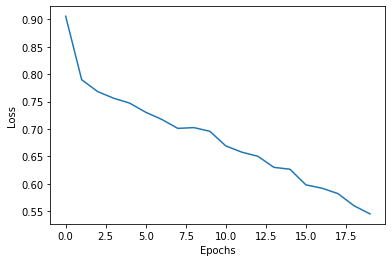

In [50]:
g = sns.lineplot(x=range(20),y=history2.history['loss'])
#g.set_ylabels("Survived")
#g.set_axis_labels("Epochs", "Validation Loss")
g.set_xlabel("Epochs")
g.set_ylabel("Loss")

Text(0, 0.5, 'Validation Loss')

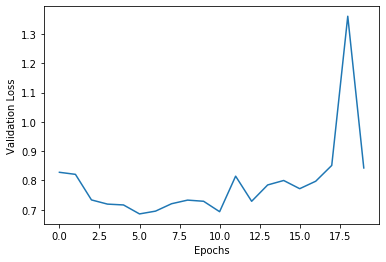

In [48]:
g = sns.lineplot(x=range(20),y=history2.history['val_loss'])
#g.set_ylabels("Survived")
#g.set_axis_labels("Epochs", "Validation Loss")
g.set_xlabel("Epochs")
g.set_ylabel("Validation Loss")

# Train the model for a few more epochs!
From Zeyang: "You can just reload the model and set the epoch to 2. The codes are similar to where you load the model and test it on testing data."

In [51]:
##Load model
from keras.models import model_from_json

#nevermind I'm copying these back to home bc WEIRD PERMISSIONS PROBLEMS AGAIN
model_weights2 = "/home/hmummey/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.h5"
model_json2 = "/home/hmummey/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.json"

model2 = model_from_json(open(model_json2).read())
model2.load_weights(model_weights2)
model2.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])


In [52]:
history22 = model2.fit(x=x_trainn, y=y_trainn,
            batch_size=batch_size,
            epochs=2,
            verbose=1,
            validation_data=(x_validn, y_validn))

Train on 15132 samples, validate on 732 samples
Epoch 1/2
15132/15132 [==============================] - 173s 11ms/step - loss: 0.5459 - accuracy: 0.8584 - val_loss: 0.7660 - val_accuracy: 0.7336
Epoch 2/2
15132/15132 [==============================] - 161s 11ms/step - loss: 0.5000 - accuracy: 0.8783 - val_loss: 0.8076 - val_accuracy: 0.7131


In [58]:
#tried to save to here but ERRORED
#keras_model_weights2 = "/home/hmummey/model/210302_NCoRWT_secondset/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.h5"
#keras_model_json2 = "/home/hmummey/model/210301_NCoRWT_secondset/modelWeights.300bp.NCoRWT.AMLNdiff.epo20.RandomShift0bp.json"

#instead saved here initially and then moved to ^ folder
keras_model_weights22 = "/home/hmummey/modelWeights.300bp.NCoRWT.AMLNdiff.epo22.RandomShift0bp.h5"
keras_model_json22 = "/home/hmummey/modelWeights.300bp.NCoRWT.AMLNdiff.epo22.RandomShift0bp.json"

json_string = model2.to_json() # architecture
with open(keras_model_json22, 'w') as json_file:
    json_file.write(json_string)
model2.save_weights(keras_model_weights22) # weights

In [53]:
total_loss = history2.history['loss'] + history22.history['loss']
print(total_loss)

total_val_loss = history2.history['val_loss'] + history22.history['val_loss']
print(total_val_loss)

[0.9058969054246055, 0.7899168086940574, 0.7681895516992024, 0.7560780270371272, 0.7471004314060852, 0.7304529274798813, 0.7173855172683409, 0.7010258295502638, 0.7024193107372801, 0.6957466349758045, 0.6689210364089389, 0.6575335866712307, 0.6500599686270065, 0.6298298395061317, 0.6263966490092368, 0.5978012077398096, 0.59174581925736, 0.5818620890245026, 0.5596955218013872, 0.5447595157211746, 0.5458696064591692, 0.4999642167619508]
[0.8277466528402652, 0.8207191176753227, 0.7333678241635933, 0.719034732039509, 0.7161556762424323, 0.6855276344252414, 0.6950503737548661, 0.7203214745052525, 0.7326902340018684, 0.7287508174369896, 0.6931341482641918, 0.8145184539706329, 0.7287023878488385, 0.7845110215775953, 0.7997506909031685, 0.7717135050257699, 0.7972269761757772, 0.8512004952613121, 1.3609930192186532, 0.8426094612137216, 0.7660481636641455, 0.8075820959982325]


Text(0, 0.5, 'Loss')

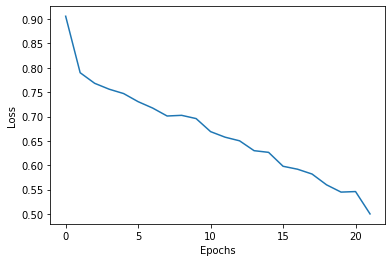

In [57]:
g = sns.lineplot(x=range(22),y=total_loss)
g.set_xlabel("Epochs")
g.set_ylabel("Loss")

Text(0, 0.5, 'Validation Loss')

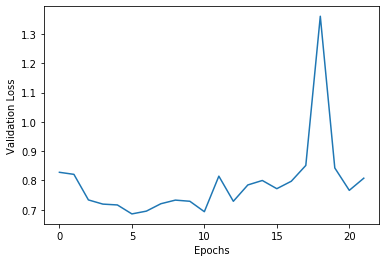

In [56]:
g = sns.lineplot(x=range(22),y=total_val_loss)
g.set_xlabel("Epochs")
g.set_ylabel("Validation Loss")

In [59]:
##Load model
from keras.models import model_from_json

#nevermind I'm copying these back to home bc WEIRD PERMISSIONS PROBLEMS AGAIN
model_weights22 = "/home/hmummey/modelWeights.300bp.NCoRWT.AMLNdiff.epo22.RandomShift0bp.h5"
model_json22 = "/home/hmummey/modelWeights.300bp.NCoRWT.AMLNdiff.epo22.RandomShift0bp.json"

model22 = model_from_json(open(model_json22).read())
model22.load_weights(model_weights22)
model22.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])

preds22 = model22.predict(x_validn).flatten()

from sklearn import metrics
fpr22, tpr22, thresholds22 = metrics.roc_curve(y_validn, preds22, pos_label=1)
print('AUC:', metrics.auc(fpr22, tpr22))
print('Accuracy:', metrics.accuracy_score(y_validn, (preds22>0.5)*1))

AUC: 0.7859311892296185
Accuracy: 0.7131147540983607
